# Разведочный анализ данных абитуриентов ИИК

In [650]:
# подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [651]:
# считывание данных
path = 'priem16_23.csv'

data = pd.read_csv(path, sep=';')
data.head()

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Вид приема,Набор ОП,Сумма баллов,р.я,инф,мат,физ,Баллы за индивидуальные достижения,Сумма баллов за индивидуальные достижения,Год поступления
0,М,нет,Казахстан,"""Интеллектуальная школа физико-математического...",Общий конкурс,10.03.01 Информационная безопасность,227,70.0,NaN,96.0,61.0,NaN,0,2019
1,М,да,Нигерия,"""Колледж Notre Dame"" D'aArique Bietry, Кот Д'И...",По договору,10.03.01 Информационная безопасность,143,42.0,NaN,53.0,48.0,NaN,0,2018
2,М,да,Казахстан,"""Общеобразовательная средняя школа №43"" отдела...",Общий конкурс,11.03.04 Электроника и наноэлектроника,190,65.0,NaN,76.0,49.0,NaN,0,2019
3,М,нет,Казахстан,"""Средняя общеобразовательная школа №16"" города...",Общий конкурс,09.03.01 Информатика и вычислительная техника,232,73.0,NaN,96.0,63.0,NaN,0,2019
4,М,да,Казахстан,"""Средняя общеобразовательная школа №7"" города ...",Общий конкурс,11.03.04 Электроника и наноэлектроника,189,75.0,NaN,56.0,48.0,1. Победитель/призер Международной предметной ...,10,2019


## Первичная обработка

In [652]:
# посмотрим краткую сводку
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846 entries, 0 to 5845
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Пол                                        5846 non-null   object 
 1   Нуждается в общежитии                      5846 non-null   object 
 2   Иностранное гражданство                    121 non-null    object 
 3   Школа                                      5846 non-null   object 
 4   Вид приема                                 5846 non-null   object 
 5   Набор ОП                                   4815 non-null   object 
 6   Сумма баллов                               5846 non-null   int64  
 7   р.я                                        3640 non-null   float64
 8   инф                                        939 non-null    float64
 9   мат                                        3569 non-null   float64
 10  физ                     

In [653]:
data['Вид приема'].value_counts()

Вид приема
Общий конкурс                               5191
По договору                                  256
Целевой прием                                228
В рамках квоты лиц, имеющих особые права      82
Без ВИ в рамках КЦП                           46
Отдельная квота                               19
Особая квота                                  14
Без ВИ                                        10
Name: count, dtype: int64

In [654]:
# 0. Для анализа оставим только поступление на бюджет,
# т.е. только тех студентов, у которых "Вид приема" - "Общий конкурс".
# Также, т.к. нам нужно провести анализ, касающийся выбора направления, оставим только тех студентов,
# у которых не пропущено значение "Набор ОП"
data = data[(data['Набор ОП'].notna()) & (data['Вид приема'] == 'Общий конкурс')]

# Удалим лишний столбец
data.drop(columns='Вид приема', inplace=True)

In [655]:
# 1. Преобразуем даные в графе "пол" - М=мужской, Ж=женский
data['Пол'] = data['Пол'].apply(lambda x: 'мужской' if x == 'М' else 'женский')

In [656]:
# 2. Вместо полей "информатика" и "физика" заведем два поля: "3балл " и "3экз" - в одном балл по физике или информатике, 
# в другом строка, в которой написан предмет, по которому сдан экзамен (физика или информатика).
data['3балл'] = data[['инф', 'физ']].max(axis=1)
data['3экз'] = data[['инф', 'физ']].idxmax(axis="columns")
# если значений баллы по физике и информатике не указаны, в новых столбцах будет NaN

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_13148\2470291945.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data['3экз'] = data[['инф', 'физ']].idxmax(axis="columns")


In [657]:
# Удалим лишние столбцы
data.drop(columns=['инф', 'физ'], inplace=True)

In [658]:
# 3. Баллы за индивидуальные достижения трансформируем в два булевых столбца: "олимпиада" и "медаль"
# Сначала посмотрим, какие достижения бывают
individual_achievements = []

data[data['Баллы за индивидуальные достижения'].notna()]['Баллы за индивидуальные достижения'].apply(lambda x: individual_achievements.append(x.split('\n')))

from itertools import chain

individual_achievements = list(chain.from_iterable(individual_achievements))
individual_achievements = set(sorted(map(lambda x: x.replace('1. ', '').replace('2. ', '').replace('3. ', '')
                                                            .replace('4. ', '').replace('5. ', ''), individual_achievements)))

In [659]:
individual_achievements

{'Аттестат о среднем (полном) общем образовании, золотая медаль — 5',
 'Аттестат о среднем (полном) общем образовании, золотая медаль — 5\r',
 'Аттестат о среднем (полном) общем образовании, серебряная медаль — 5',
 'Аттестат о среднем общем образовании с отличием — 5',
 'Аттестат о среднем общем образовании с отличием — 5\r',
 'Диплом о среднем профессиональном образовании с отличием — 5',
 'Документ об образовании или об образовании и о квалификации с отличием — 5',
 'Документ об образовании или об образовании и о квалификации с отличием — 5\r',
 'Золотой знак отличия ГТО — 2',
 'Золотой знак отличия ГТО — 2\r',
 'Лауреат Всероссийских Юношеских научных чтений имени С.П. Королёва — 5',
 'Лауреат Всероссийских Юношеских научных чтений имени С.П. Королёва — 5\r',
 'Лауреат Молодёжной научной конференции "Королёвские чтения: школьники" — 5\r',
 'Лауреат Самарской научно-образовательной  программы «Взлет» — 3',
 'Лауреат Самарской научно-образовательной  программы «Взлет» — 3\r',
 'Лауре

In [660]:
# Создадим столбец "Достижения", в котором будут списки достижений студентов
def f(x):
    return x.replace('1. ', '').replace('2. ', '').replace('3. ', '').replace('4. ', '').replace('5. ', '').split('\n')


data['Баллы за индивидуальные достижения'].fillna('', inplace=True)
data['Достижения'] = data['Баллы за индивидуальные достижения'].apply(lambda x: f(x))

In [661]:
data.sample(n=5)

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Набор ОП,Сумма баллов,р.я,мат,Баллы за индивидуальные достижения,Сумма баллов за индивидуальные достижения,Год поступления,3балл,3экз,Достижения
1277,женский,нет,NaN,"МБОУ ""Школа №63 с углубленным изучением отдель...",09.03.01 Информатика и вычислительная техника,222,82.0,70.0,,0,2018,70.0,физ,[]
4058,мужской,нет,NaN,ГБОУ Самарской области СОШ №3 имени З.А.Космод...,01.03.03 Механика и математическое моделирован...,206,71.0,76.0,,0,2022,59.0,физ,[]
2835,женский,да,NaN,"МБОУ ""Красногвардейская гимназия"" с. Донское К...",01.03.02 Прикладная математика и информатика (...,182,NaN,NaN,,0,2016,NaN,NaN,[]
4445,женский,нет,NaN,"МБОУ ""Школа №168 имени Героя Советского Союза ...",10.03.01 Информационная безопасность,223,82.0,68.0,,0,2022,73.0,инф,[]
1471,мужской,да,NaN,"МБОУ городского округа Тольятти ""Школа №90"", Р...",11.03.03 Конструирование и технология электрон...,260,96.0,86.0,,0,2019,78.0,физ,[]


In [662]:
# все достижения разделим на 4 категории
military_achievs = {'Прохождение военной службы — 10'} # Военная служба
sport_achievs = {'Золотой знак отличия ГТО — 2'} # ГТО
medal_achievs = {'Аттестат о среднем (полном) общем образовании, золотая медаль — 5',
 'Аттестат о среднем (полном) общем образовании, серебряная медаль — 5',
 'Аттестат о среднем общем образовании с отличием — 5',
 'Диплом о среднем профессиональном образовании с отличием — 5',
 'Документ об образовании или об образовании и о квалификации с отличием — 5'} # Медаль
scientific_achievs = individual_achievements - military_achievs - sport_achievs - medal_achievs # Олимпиада

In [663]:
# Создадим 4 новых булевых столбца для каждого типа достижений
data['Военная служба'] = data['Достижения'].apply(lambda x: True if set(x) & military_achievs else False)
data['ГТО'] = data['Достижения'].apply(lambda x: True if set(x) & sport_achievs else False)
data['Медаль'] = data['Достижения'].apply(lambda x: True if set(x) & medal_achievs else False)
data['Олимпиада'] = data['Достижения'].apply(lambda x: True if set(x) & scientific_achievs else False)

# Удалим лишние столбцы
data.drop(columns=['Баллы за индивидуальные достижения', 'Достижения'], inplace=True)

In [664]:
data.sample(n=5)

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Набор ОП,Сумма баллов,р.я,мат,Сумма баллов за индивидуальные достижения,Год поступления,3балл,3экз,Военная служба,ГТО,Медаль,Олимпиада
1180,мужской,нет,NaN,"МБОУ ""Школа №175"" городского округа Самара, Ро...",12.03.04 Биотехнические системы и технологии,194,78.0,56.0,0,2020,60.0,физ,False,False,False,False
1172,мужской,нет,NaN,"МБОУ ""Школа №166 имени А.А. Микулина"" городско...",02.03.02 Фундаментальная информатика и информа...,271,93.0,84.0,5,2018,89.0,физ,False,False,True,False
5625,мужской,да,NaN,Некоммерческое частное учреждение профессионал...,10.05.03 Информационная безопасность автоматиз...,263,78.0,NaN,7,2023,NaN,NaN,False,False,True,True
4570,женский,нет,NaN,МОУ СОШ с углубленным изучением отдельных пред...,12.03.04 Биотехнические системы и технологии,207,89.0,66.0,0,2022,NaN,NaN,False,False,False,False
311,женский,нет,NaN,ГБОУ Самарской области СОШ с.Домашка муниципал...,12.03.05 Лазерная техника и лазерные технологии,228,96.0,68.0,5,2020,59.0,физ,False,False,True,False


In [665]:
# 4. Распарсим столбец "Школа"
# Проверим, одинаковый ли формат у даных
# Создадим вспомогательный столбец
data['Количество информации о школе'] = data['Школа'].apply(lambda x: len(x.split(',')))

In [666]:
data['Количество информации о школе'].value_counts()

Количество информации о школе
4    3368
5     738
3      82
6      11
7       2
8       1
Name: count, dtype: int64

In [667]:
# Изучив данные, можно сделать вывод, что в зависимости от "Количества информации" записи должны иметь следующий вид:
# 3 - школа, страна, город
# 4 - школа, страна, город, область
# 5 - школа, страна, город, область, район
# Конечно, не все записи подходят под это правило, у некоторых в названии школы есть запятые,
# у некоторых повторяются данные о населенном пункте и из-за этого другой порядок.
# Однако таких записей мало, поэтому оставим только те, которые подходят под правило. 
# Отберем записи, у которых после первой запятой действительно страна
# countries = ['Россия', 'Казахстан', 'Таджикистан', 'Беларусь', 'Узбекистан', 'Украина'] 
countries = list(data['Иностранное гражданство'].unique())
countries

['Казахстан', nan, 'Узбекистан', 'Беларусь', 'Украина', 'Таджикистан']

In [668]:
# удалим nan и добавим Россию
countries.pop(1)
countries.append('Россия')

data.shape

(4202, 17)

In [669]:
data = data[data['Школа'].apply(lambda x: x.split(',')[1].strip() in countries)]
data.shape
# Как мы видим, потеряно не много записей

(4132, 17)

In [670]:
# Можно увидеть, что на 3-м месте действительно населенные пункты
data['Школа'].apply(lambda x: x.split(',')[2]).unique()

array([' г. Уральск', ' г. Самара (63)', ' г. Тольятти (63)',
       ' г. Ханты-Мансийск (86)', ' г. Вологда (35)', ' г. Элиста (08)',
       ' г. Нефтегорск (63)', ' г. Новокуйбышевск (63)',
       ' пгт. Безенчук (63)', ' г. Оренбург (56)', ' г. Курган (45)',
       ' г. Сызрань (63)', ' г. Жигулевск (63)', ' г. Октябрьск (63)',
       ' г. Отрадный (63)', ' г. Похвистнево (63)', ' с. Исаклы (63)',
       ' г. Кинель (63)', ' с. Красноармейское (63)',
       ' п. Придорожный (63)', ' с. Челно-Вершины (63)',
       ' с. Украинка (63)', ' пгт. Новосемейкино (63)', ' обл. Самарская',
       ' с. Кротовка (63)', ' с. Петровка (63)', ' с. Съезжее (63)',
       ' с. Тимашево (63)', ' с. Четырла (63)', ' с. Утевка (63)',
       ' г. Чапаевск (63)', ' пгт. Стройкерамика (63)',
       ' ж/д_ст. Шентала (63)', ' пгт. Смышляевка (63)',
       ' пгт. Усть-Кинельский (63)', ' с. Обшаровка (63)',
       ' с. Приволжье (63)', ' с. Сергиевск (63)',
       ' с. Кинель-Черкассы (63)', ' с. Большая Чер

In [671]:
# Теперь распарсим колонку "Школа" на 
# Школа, Страна, Населенный пункт
data['Населенный пункт'] = data['Школа'].apply(lambda x: x.split(',')[2])
data['Страна'] = data['Школа'].apply(lambda x: x.split(',')[1])
data['Школа'] = data['Школа'].apply(lambda x: x.split(',')[0])

# Удалим лишние столбцы
data.drop(columns=['Количество информации о школе', 'Иностранное гражданство'], inplace=True)

In [672]:
# Во всех названиях школ уберем пробел между "№" и номером школы, чтобы не было дублей типа
# МБОУ "Школа № 10 "Успех" городского округа Самара
# МБОУ "Школа №10 "Успех" городского округа Самара
data['Школа'] = data['Школа'].apply(lambda x: x.replace('№ ', '№'))

In [673]:
# Для лучшей читаемости на графиках переименуем названия направлений на аббревиатуры
data['Набор ОП'].unique()

array(['10.03.01 Информационная безопасность',
       '11.03.04 Электроника и наноэлектроника',
       '09.03.01 Информатика и вычислительная техника',
       '02.03.02 Фундаментальная информатика и информационные технологии',
       '10.05.01 Компьютерная безопасность',
       '11.05.01 Радиоэлектронные системы и комплексы',
       '03.03.01 Прикладные математика и физика',
       '11.03.03 Конструирование и технология электронных средств',
       '12.03.05 Лазерная техника и лазерные технологии',
       '02.03.03 Математическое обеспечение и администрирование информационных систем',
       '10.05.03 Информационная безопасность автоматизированных систем',
       '01.05.01 Фундаментальные математика и механика',
       '01.03.02 Прикладная математика и информатика',
       '11.03.01 Радиотехника',
       '12.03.04 Биотехнические системы и технологии',
       '01.03.02 Прикладная математика и информатика (Крым)',
       '01.03.02 Прикладная математика и информатика (Системный анализ и у

In [674]:
direction_abbreviations = {
    '10.03.01 Информационная безопасность': 'ИБ',
    '11.03.04 Электроника и наноэлектроника': 'ЭН',
    '09.03.01 Информатика и вычислительная техника': 'ИВТ',
    '02.03.02 Фундаментальная информатика и информационные технологии': 'ФИИТ',
    '10.05.01 Компьютерная безопасность': 'КБ',
    '11.05.01 Радиоэлектронные системы и комплексы': 'РСК',
    '03.03.01 Прикладные математика и физика': 'ПМФ',
    '11.03.03 Конструирование и технология электронных средств': 'КТЭС',
    '12.03.05 Лазерная техника и лазерные технологии': 'ЛТЛТ',
    '02.03.03 Математическое обеспечение и администрирование информационных систем': 'МОАИС',
    '10.05.03 Информационная безопасность автоматизированных систем': 'ИБАС',
    '01.05.01 Фундаментальные математика и механика': 'ФММ',
    '01.03.02 Прикладная математика и информатика': 'ПМИ',
    '11.03.01 Радиотехника': 'РТ',
    '12.03.04 Биотехнические системы и технологии': 'БСТ',
    '01.03.02 Прикладная математика и информатика (Крым)': 'ПМИ',
    '01.03.02 Прикладная математика и информатика (Системный анализ и управление)': 'ПМИ',
    '01.03.03 Механика и математическое моделирование (Вычислительная механика)': 'МММ',
    '01.03.03 Механика и математическое моделирование (Анализ и компьютерное моделирование аэрокосмических систем)': 'МММ',
    '02.03.01 Математика и компьютерные науки': 'МКН',
    '12.03.03 Фотоника и оптоинформатика': 'ФО'
}

data['Направление'] = data['Набор ОП'].apply(lambda x: direction_abbreviations[x])
data.drop(columns='Набор ОП', inplace=True)

In [675]:
data.sample(n=5)

,Пол,Нуждается в общежитии,Школа,Сумма баллов,р.я,мат,Сумма баллов за индивидуальные достижения,Год поступления,3балл,3экз,Военная служба,ГТО,Медаль,Олимпиада,Населенный пункт,Страна,Направление
1495,мужской,да,"МБОУ городского округа Тольятти ""Школа с углуб...",213,85.0,68.0,5,2018,55.0,физ,False,False,False,True,г. Тольятти (63),Россия,ИВТ
5167,мужской,нет,"МБОУ ""Школа №49 имени ветерана военной контрра...",174,69.0,52.0,0,2023,53.0,физ,False,False,False,False,г. Самара (63),Россия,РСК
5616,мужской,да,"МБОУ ""Средняя школа №19 имени Героя Советского...",246,79.0,74.0,5,2023,88.0,инф,False,False,True,False,г. Димитровград (73),Россия,ПМИ
1137,мужской,нет,"МБОУ ""Школа №150 имени Героя Советского Союза ...",192,76.0,62.0,0,2018,54.0,физ,False,False,False,False,г. Самара (63),Россия,МОАИС
2132,мужской,да,ГБОУ Самарской области СОШ пос. Сургут муницип...,176,NaN,NaN,0,2017,NaN,NaN,False,False,False,False,п. Сургут (63),Россия,РТ


## Анализ датасета

### Анализ относительно всего ИИК

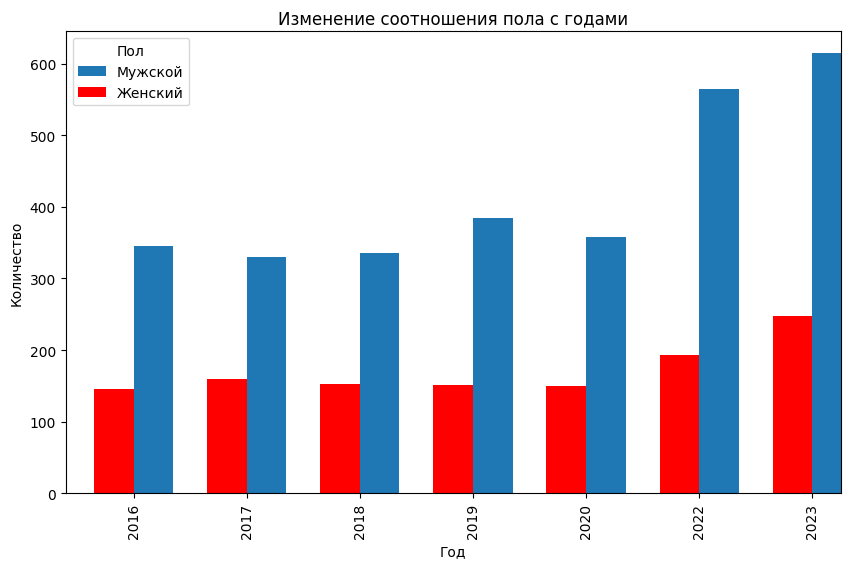

In [676]:
# Посмотрим, как менялось соотношение мужского и женского пола с годами на ИИК
grouped = data.groupby(['Год поступления', 'Пол'])['Пол'].count().unstack()

fig, ax = plt.subplots(figsize=(10, 6)) 

width = 0.35 
grouped['мужской'].plot(kind='bar', position=0, width=width, label='Мужской', ax=ax)
grouped['женский'].plot(kind='bar', position=1, width=width, label='Женский', ax=ax, color='red')


ax.set_xlabel('Год')
ax.set_ylabel('Количество')
ax.set_title('Изменение соотношения пола с годами')
ax.legend(title='Пол')

plt.show()

Как мы видим, на ИИК всегда парней было больше, чем девушек, однако с 2022 года разница увеличилась

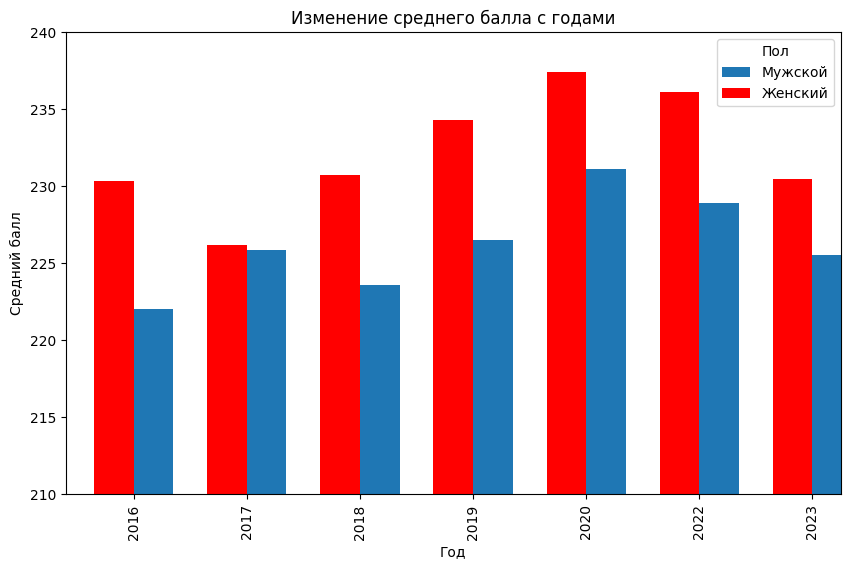

In [677]:
# Посмотрим, как менялся средний балл по полу с годами на ИИК
grouped = data.groupby(['Год поступления', 'Пол'])['Сумма баллов'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 6)) 

width = 0.35 
grouped['мужской'].plot(kind='bar', position=0, width=width, label='Мужской', ax=ax)
grouped['женский'].plot(kind='bar', position=1, width=width, label='Женский', ax=ax, color='red')


ax.set_xlabel('Год')
ax.set_ylabel('Средний балл')
ax.set_title('Изменение среднего балла с годами')
ax.legend(title='Пол')
ax.set_ylim(210, 240)
plt.show()

Заметим, что у девушек всегда средний балл был заметно выше, кроме 2017 года. События, которые могли на это повлиять:
- взлет биткоина и введение закона о поддержке молодых семей - альтернатива поступления в ВУЗ :)
- большое количество политических митингов, отмена России на Олимпиаде и Евровидении - отвлекающие и повышающие тревогу факторы

Также заметим, что до 2020 года был рост среднего балла, а затем начался спад. Это, скорее всего, связано с тем, что в 2020 году был карантин и дистанционное обучение, которые негативно сказались на подготовке к экзаменам

In [678]:
# Посмотрим статистику по школам
top_popular_schools = data.groupby('Школа')['Сумма баллов'].count().sort_values(ascending=False).head(10)
top_schools_by_olympiads = data.groupby('Школа')['Олимпиада'].sum().sort_values(ascending=False).head(10)
top_schools_by_medals = data.groupby('Школа')['Медаль'].sum().sort_values(ascending=False).head(10)

print('Больше всего абитуриентов из школ:')
print(top_popular_schools)

Больше всего абитуриентов из школ:
Школа
МБОУ "Самарский международный аэрокосмический лицей" городского округа Самара Самарской области                201
МБОУ "Лицей авиационного профиля №135" городского округа Самара                                                 79
МБОУ "Лицей "Технический" им. С.П. Королева" городского округа Самара Самарской области                         47
МАОУ "Самарский лицей информационных технологий" городского округа Самара                                       45
МБОУ "Школа №176 с углубленным изучением отдельных предметов" городского округа Самара Самарской области        32
ГБНОУ Самарской области "Самарский региональный центр для одаренных детей" города Самара                        32
ГБОУ Самарской области "Лицей авиационного профиля №135 (Базовая школа Российской академии наук)"               30
МБОУ "Школа №10 "Успех" городского округа Самара                                                                27
МБОУ "Лицей "Созвездие" №131" городског

In [679]:
print('\nБольше всего олимпиадников из школ:')
print(top_schools_by_olympiads)


Больше всего олимпиадников из школ:
Школа
МБОУ "Самарский международный аэрокосмический лицей" городского округа Самара Самарской области             67
МБОУ "Лицей авиационного профиля №135" городского округа Самара                                             21
МБОУ "Лицей "Созвездие" №131" городского округа Самара Самарской области                                    17
МБОУ "Лицей "Технический" им. С.П. Королева" городского округа Самара Самарской области                     17
ГБНОУ Самарской области "Самарский региональный центр для одаренных детей" города Самара                    13
МАОУ "Самарский лицей информационных технологий" городского округа Самара                                   11
МБОУ "Лицей "Технический" им. С.П. Королева" городского округа Самара                                        7
МБОУ "Школа №176 с углубленным изучением отдельных предметов" городского округа Самара Самарской области     7
МБОУ "Гимназия №2" городского округа Самара Самарская область        

In [680]:
print('\nБольше всего медалистов из школ:')
print(top_schools_by_medals)


Больше всего медалистов из школ:
Школа
МБОУ "Самарский международный аэрокосмический лицей" городского округа Самара Самарской области                                                     20
МБОУ "Школа №10 "Успех" городского округа Самара                                                                                                    12
ГБОУ Самарской области "Лицей авиационного профиля №135 (Базовая школа Российской академии наук)"                                                    9
ГБОУ Самарской области СОШ №1 п.г.т. Безенчук муниципального района Безенчукский Самарской области                                                   9
МБОУ "Лицей авиационного профиля №135" городского округа Самара                                                                                      8
МБОУ "Лицей "Технический" им. С.П. Королева" городского округа Самара Самарской области                                                              8
МБОУ "Школа №122 имени Дороднова В.Г." городского окру

Видно, что очень много поступивших из образовательных учреждений при университете, что логично. Также заметим, что на ИИК поступают выпускники лучших школ Самары (по версии RAEX: https://raex-rr.com/education/school_regions/Samara_Region/2023/), об этом также свидетельствует большое количество олимпиадников из этих школ. Интересно, что список образовательных учреждений с наибольшим количество медалистов отличается уже сильнее. Возможно, это связано с тем, что сложность получения медали в разных школах разная (в отличие от сложности победы в олимпиаде) и поэтому в список могли попасть школы, где просто легко получить медаль

### Анализ относительно популярных направлений - ИБАС, ФИИТ, ПМИ, ИВТ

In [681]:
# Для удобства оставим только записи с популярными направлениями
popular_directions = ['ИБАС', 'ФИИТ', 'ПМИ', 'ИВТ']

data = data[data['Направление'].isin(popular_directions)]

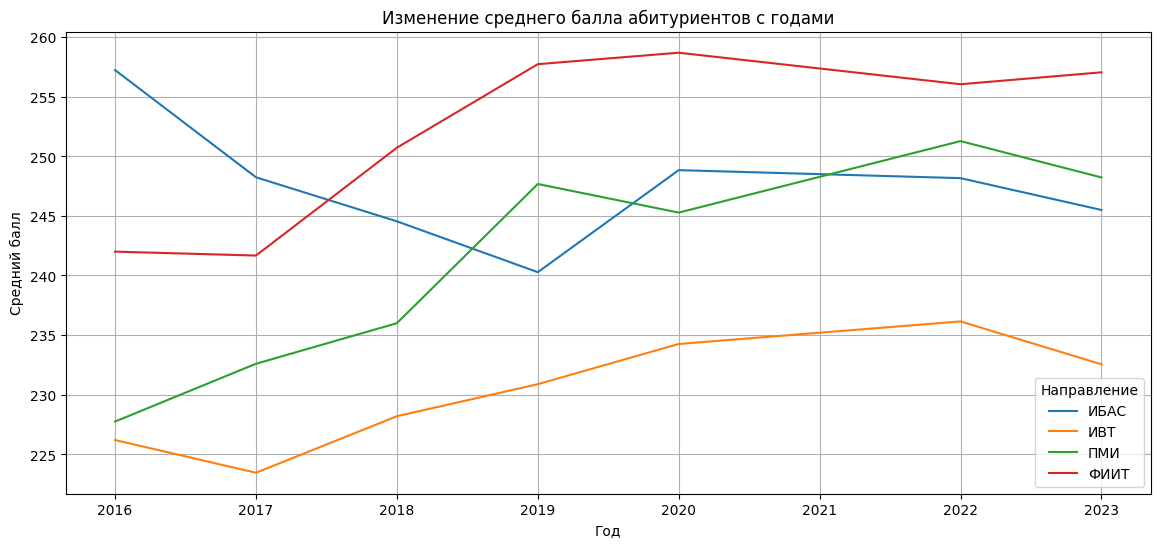

In [682]:
# Посмотрим, как менялся средний балл на направлениях с годами
grouped = data.groupby(['Год поступления', 'Направление'])['Сумма баллов'].mean().unstack()

fig, ax = plt.subplots(figsize=(14, 6)) 

grouped.plot(kind='line', ax=ax)

plt.grid(True)
ax.set_xlabel('Год')
ax.set_ylabel('Средний балл')
ax.set_title('Изменение среднего балла абитуриентов с годами')
ax.legend(title='Направление')
plt.show()

Графики ФИИТ, ПМИ и ИВТ довольно похожи, до 2020 грода был наибольший рост, после чего средний балл перестал значительно изменяться. У ИБАС же до 2019 был сильный спад, рост в 2020 (возможно, связано с обновлением программы обучения), и также выход на плато после. При этом у ФИИТ почти всегда был самый высокий средний балл (скорее всего, потому что на этом направлении заявлено больше всего программирования и меньше всего математики, отсюда больше желающих поступить), у ИВТ - самый низкий, ИБАС и ПМИ с 2020 имеют примерно одинаковые баллы.

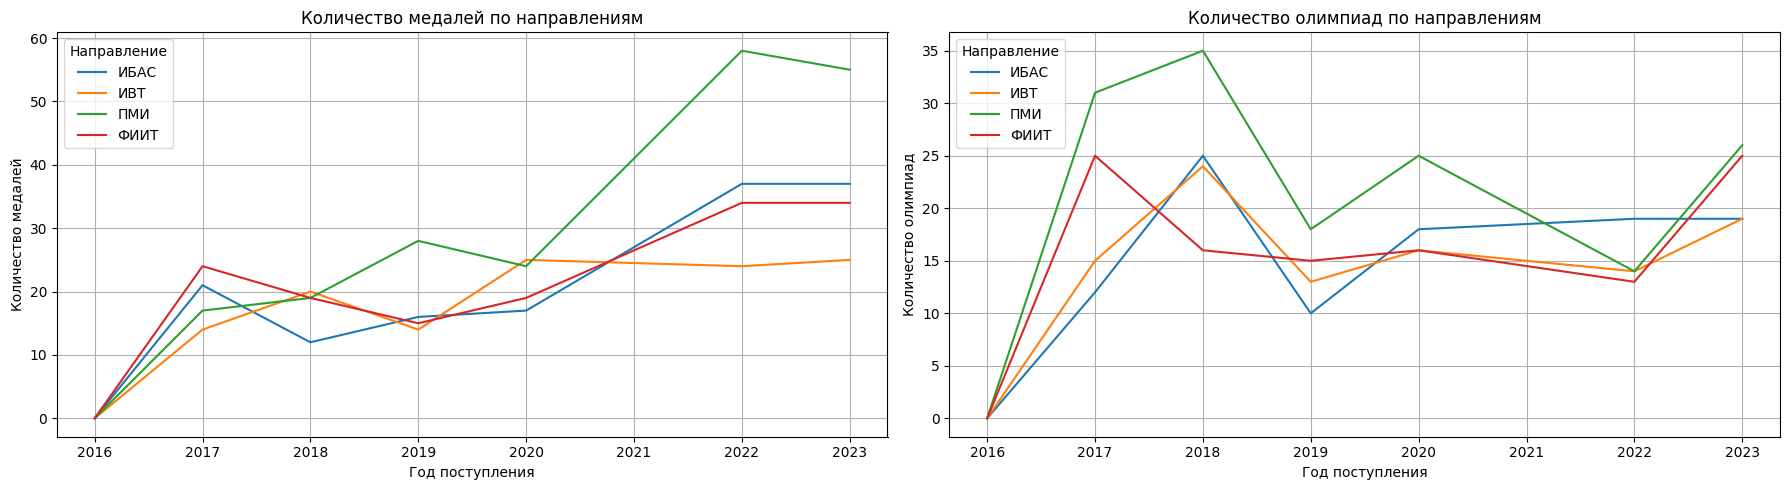

In [683]:
# Посмотрим, как менялся количество олимпиадников и медалистов на направлениях с годами
grouped_1 = data.groupby(['Год поступления', 'Направление'])['Медаль'].sum().unstack()
grouped_2 = data.groupby(['Год поступления', 'Направление'])['Олимпиада'].sum().unstack()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5)) 

grouped_1.plot(kind='line', ax=ax1)  
ax1.set_title('Количество медалистов по направлениям')
ax1.set_xlabel('Год поступления')
ax1.set_ylabel('Количество медалистов')
ax1.legend(title='Направление')
ax1.grid(True)

grouped_2.plot(kind='line', ax=ax2)
ax2.set_title('Количество олимпиадников по направлениям')
ax2.set_xlabel('Год поступления')
ax2.set_ylabel('Количество олимпиадников')
ax2.legend(title='Направление')
ax2.grid(True)

plt.tight_layout() 
plt.show()

На обоих графиках наблюдается похожий тренд на всех направлениях, при этом на ПМИ олимпиадников и медалистов заметно больше. На 2-ом графике виден спад в 2018 году, который, скорее всего, связан с тем, что за индивидуальные достижение стали давать меньше баллов.

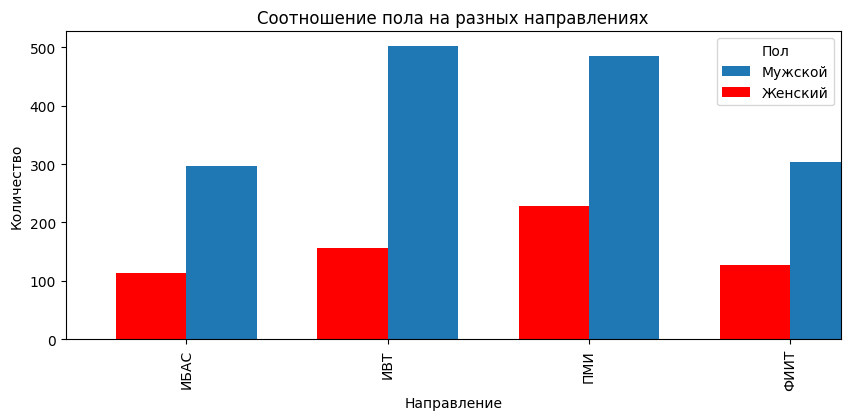

In [688]:
# Посмотрим на соотношение мужского и женского пола на разных направлениях
grouped = data.groupby(['Направление', 'Пол'])['Пол'].count().unstack()

fig, ax = plt.subplots(figsize=(10, 4)) 

width = 0.35 
grouped['мужской'].plot(kind='bar', position=0, width=width, label='Мужской', ax=ax)
grouped['женский'].plot(kind='bar', position=1, width=width, label='Женский', ax=ax, color='red')


ax.set_xlabel('Направление')
ax.set_ylabel('Количество')
ax.set_title('Соотношение пола на разных направлениях')
ax.legend(title='Пол')

plt.show()

Как и на всём ИИК, преобладает мужской пол причем примерно в равном соотношении на ИБАС, ПМИ и ФИИТ. На ИВТ разница больше, что, возможно, связано с тем, что это направление более техническое.

Можно сделать следующие выводы:
- ФИИТ обещает много программирования, поэтому на этом навправлении наибольший конкурс и, следовательно, наибольший средний балл. Можно предположить, что сюда поступают те, кто хочет больше практики и меньше интересуется наукой и учебой - самые высокие баллы ЕГЭ при относительно небольшом количестве олимпиадников и медалистов;
- на ПМИ напротив идут ребята, которым больше интересна наука - наибольшее количество олимпиадников и медалистов, высокие баллы;
- после крупного обновления программы обучения на ИБАС заметно выросли средний балл, количество олимпиадников и медалистов. Благодаря вариативности учебного плана, у данного направления млжет быть разнообразная аудитория абитуриентов
- на ИВТ самый большой дисбаланс по полу, самые низкие баллы и наименьшее количество олимпиадников и медалистов